/Users/ivo/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


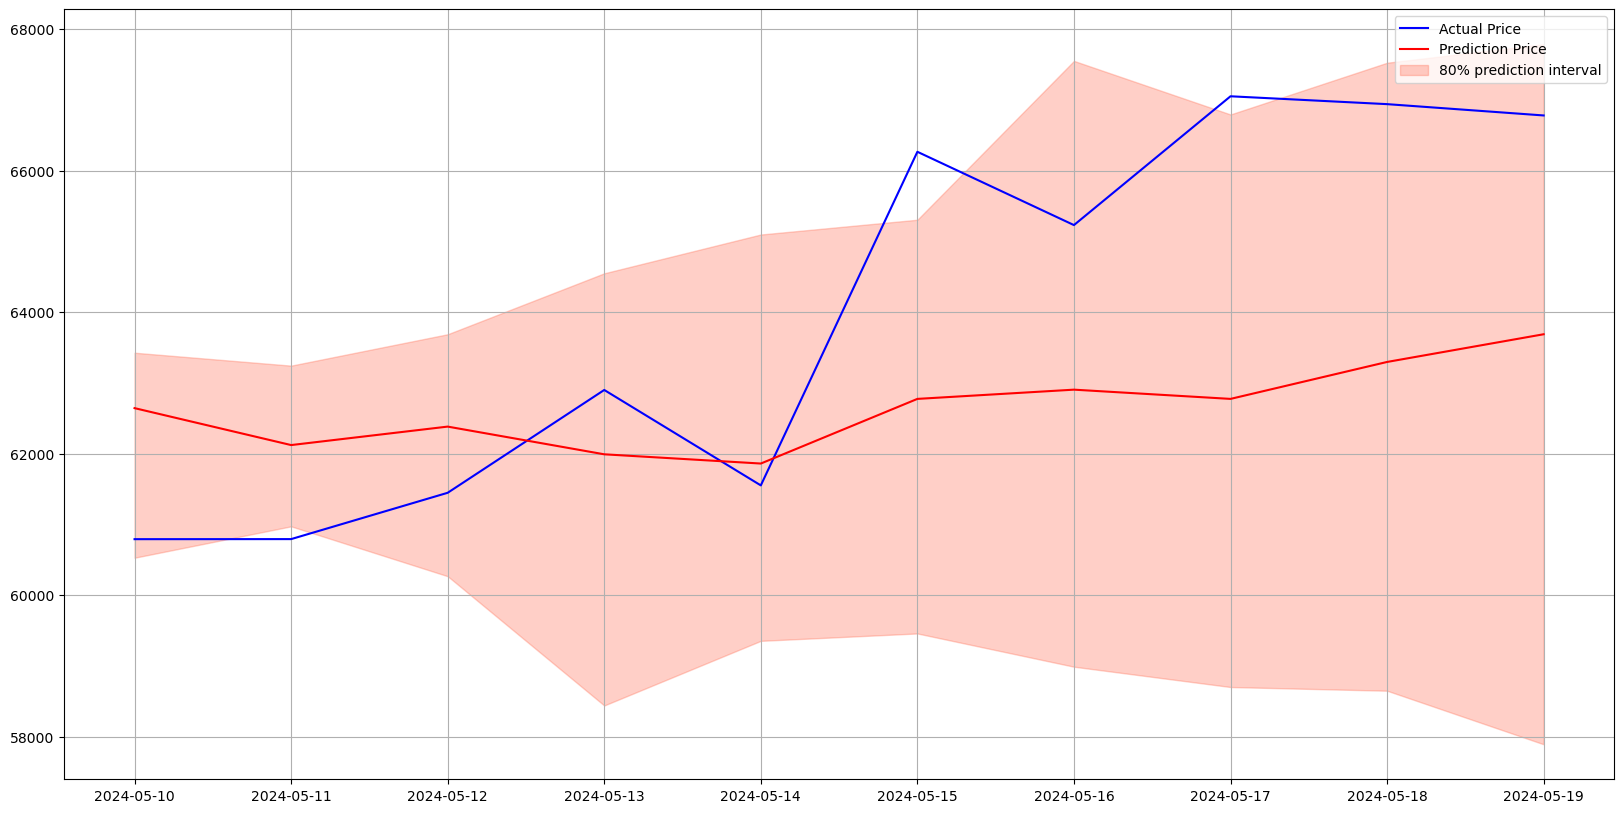

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosPipeline
import yfinance as yf


df = pd.read_csv("BTC-USD.csv", index_col="Date", parse_dates=True)
df.dropna(inplace=True)

dias = 10

train_size = int(len(df) - dias)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]


#Hacemos las predicciones
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

prediction_length = dias
context = torch.tensor(train_df["Close"])
forecast = pipeline.predict(context, prediction_length)

low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


plt.figure(figsize=(20,10))
#plt.plot(train_df.index, train_df["Close"], label="Close Price", color="black")
plt.plot(test_df.index, test_df["Close"], label="Actual Price",color="blue")
plt.plot(test_df.index, median, color="red", label="Prediction Price")
plt.fill_between(test_df.index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid(True)
plt.show()




